<a href="https://colab.research.google.com/github/Ahmed-Wassel-Angar/Project-2/blob/main/Project_2_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [8]:
import pandas as pd
pd.set_option('display.max_columns',None)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import math
from google.colab import data_table
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')


In [6]:
from google.colab import drive
drive.mount("/content/drive")
df= pd.read_csv("/content/drive/MyDrive/Coding Dojo/Project 2/healthcare-dataset-stroke-data.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Instantiating Customized Functions**

In [7]:
#@title **Overview Data**

def overview_data(dataset):
  from google.colab import data_table
  data_table.enable_dataframe_formatter()

  df=dataset.copy()
  header="-"*25

  print(2*header,"START - OVERVIEW DATA",2*header)
  display(df)

  print(4*header, f"Dataset Statistics:", 4*header, sep='\n')

  num_cols = df.select_dtypes('number').columns
  cat_cols = df.select_dtypes('object').columns
  nbr_num_cols = len(num_cols)
  nbr_cat_cols = len(cat_cols)
  nbr_duplicated = df.duplicated().sum()
  nbr_missing = df.isna().sum().sum()
  nbr_obsol_rows = df.shape[0]-len(df.dropna(how='all'))
  nbr_obsol_columns = df.shape[1]-len(df.dropna(how='all',axis=1).columns)

  overview=pd.Series(index=["Number of variables:","Number of observations:","Duplicated rows:","Obsolete rows(empty rows):","Obsolete variables(empty columns):","Total Missing Values:"],
                     data=[f"{df.shape[1]} ({nbr_num_cols} numeric and {nbr_cat_cols} categorical)",
                           f"{df.shape[0]}",
                           f"{nbr_duplicated} ({nbr_duplicated/df.shape[0] *100:,.2f}%)",
                           f"{nbr_obsol_rows} ({nbr_obsol_rows/df.shape[0] *100:,.2f}%)",
                           f"{nbr_obsol_columns} ({nbr_obsol_columns/df.shape[1] *100:,.2f}%)",
                           f"{nbr_missing} ({nbr_missing/df.shape[0] *100:,.2f}%)"])
  print(overview.to_string())

  print(4*header, f"Numeric features: {nbr_num_cols} columns", sep='\n')
  print(num_cols.values)

  print(4*header, f"Categorical features: {nbr_cat_cols} columns", sep='\n')
  print(cat_cols.values)

  print(4*header, f"Missing Values per feature:", sep='\n')
  frame={'Counts':len(df)-df.isna().sum(),
         'Missing values':df.isna().sum(),
         'Percentage':df.isna().sum()/df.shape[0] *100}
  missing_values_counts = pd.DataFrame(frame)
  missing_values_counts.loc[:,"Percentage"]=missing_values_counts["Percentage"].map('{:,.2f} %'.format)
  #display(missing_values_counts.style)
  print(missing_values_counts)
  msno.matrix(df,figsize=(10,4))
  #msno.heatmap(df,ax=axes[1])
  plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
  plt.show()

  data_table.disable_dataframe_formatter()

  print(2*header,"END - OVERVIEW DATA",2*header)


In [9]:
# @title **Explore numeric features**
def explore_numeric(df,columns=None,target=None,iqr_coef=1.5,imb_threshold=0.1,out_threshold=0.05,corr_threshold=0.3):
  #sns.set_style("whitegrid")
  header="-"*25

  if columns is None:
    num_cols = df.select_dtypes('number').columns
  else:
    num_cols = df[columns].select_dtypes('number').columns

  print(2*header,"START - EXPLORE NUMERIC",2*header)
  print(" "*80,sep="\n")
  print(f"Numeric features: {len(num_cols)} columns",sep="\n")
  print(f"List of columns: {num_cols.values}  ",sep="\n")
  print(" "*80," "*80,sep="\n")

  for col in num_cols:
    v= df[col]
    miss_val = v.isna().sum()
    miss_val_perc = round(miss_val/v.shape[0]*100,2)
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    iqr = q3 - q1
    out_v = v[(v <= q1 - 1.5 * iqr) | (v >= q3 + 1.5 * iqr)]
    outliers=out_v.shape[0]
    out_perc = round((outliers * 100 / df.shape[0]),2)
    statistics=pd.DataFrame({'Descriptive statistics':['Mean','STD','Variance','Coef. of variation(CV)','Kurtosis','Skewness','Medain Abs. Dev.(DAV)','Range',"Outliers","Outliers(%)",""],
                           '':[v.mean(),v.std(),v.var(),v.std()/v.mean(),v.kurt(),v.skew(),v.mad(),v.max()-v.min(),outliers,out_perc,""],
                           'Quantile statistics':['Minimum','5-th percentile','Q1','Median','Q3','95-th percentile','Maximum','IQR',"Lower Whisker","Upper whisker",""],
                           ' ':[v.min(),v.quantile(q=0.05),q1,v.quantile(q=0.5),q3,v.quantile(q=0.95),v.max(),q3-q1,q1-iqr_coef*(q3-q1),q3+iqr_coef*(q3-q1),""],
                             })
    val_counts=v.value_counts(dropna=False).sort_values(ascending=False)
    top_10_freq=val_counts if len(val_counts)<10 else val_counts.head(10)
    top_10_freq_perc = round(top_10_freq/v.shape[0]*100,3)
    val_counts_frame=pd.DataFrame({'Top 10 Values':top_10_freq.index.values,
                            'Counts':top_10_freq.values,
                            'Frequency(%)':top_10_freq_perc.values})
    if len(val_counts)>=10:
      val_counts_frame.loc[len(val_counts_frame.index)] = ['Other',val_counts.values.sum()-top_10_freq.values.sum(),round((val_counts.values.sum()-top_10_freq.values.sum())/val_counts.values.sum()*100,2)]
    statistics=pd.concat([statistics,val_counts_frame],axis=1)
    statistics.loc[1:]=statistics.loc[1:].fillna("")

    gridspec={'height_ratios':[0.7,0.3]}
    fig, axes = plt.subplots(nrows=2,figsize=(7,4),sharex=True,gridspec_kw=gridspec)
    axes=axes.flatten()
    sns.histplot(df[col],ax=axes[0],kde=True,alpha=0.6,palette='Purples')
    sns.despine(top=True, right=True, bottom=True, left=True)
    axes[0].axvline(v.mean(),color='red', ls='--',label=f"Mean Value = {v.mean():,.2f}")
    axes[0].axvline(v.median(),color='black', ls='--',label=f"Median Value = {v.median():,.2f}",)
    axes[0].legend(bbox_to_anchor=(1,0),ncol=2,fontsize=10)
    axes[0].set_ylabel(f"Counts for {col}")
    axes[0].set_xlabel("")
    sns.boxplot(data=df,x=col,ax=axes[1],showmeans=True,whis=iqr_coef,width=0.5,saturation=0.75,fliersize=2,linewidth=1,meanprops={'marker':'o','markerfacecolor':'red','markeredgecolor':'black','markersize':'4'},palette="Purples")
    axes[1].set_xlabel("")
    sns.despine(ax=axes[1],top=True, right=True, bottom=False, left=True)
    plt.tick_params(axis='both',grid_alpha=0.5)
    plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=0.5)


    print(4*header,f"  {col}: numeric column - Nulls: {miss_val}({miss_val_perc}%) - {v.dtypes} - {len(val_counts)} distinct values",4*header,sep="\n")
    print(statistics.to_string(index=False))
    print(" "*80,sep="\n")

    print(4*header,f"Alerts for feature '{col}':",sep="\n")
    val_counts_noNans=v.value_counts()
    values=val_counts_noNans.values
    if len(val_counts_noNans)>10:
      print(f"- [!] Warning: High cardinality(nbr of classes >10) detected within column {col}, {len(val_counts_noNans)} unique values detected!")
    else:
      for i in range(len(val_counts_noNans)):
        if (values[i]/values.sum()) > (1+imb_threshold)/len(values):
          print(f"- [!] Warning: Class imbalance detected within column '{col}'")
          break
    most_common_val = val_counts_noNans.index[0]
    freq = val_counts_noNans.values[0]
    perc_most_common = freq / len(df) * 100
    print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
    if perc_most_common > 98:
      print(f"- [!] Warning: '{col}' is a constant or quasi-constant feature and should be dropped.")
    else:
      print("- Not constant or quasi-constant(threshold at 98%).")
    if out_perc >= round(out_threshold*100,2):
      print(f"- [!] Warning: Number of outliers exceeded the threshold of {round(out_threshold*100,2)}% .")
    else:
      print("- No outliers detected above the level of {round(out_threshold*100,2)}%")
    if v.is_unique:
      print(f"- [!] Warning: '{col}' has unique values.")
    print(" "*80,sep="\n")

    print(4*header,f"Distribution of '{col}':",sep="\n")
    plt.show()
    print(" "*80," "*80,sep="\n")

  if len(num_cols)>1:
    print(4*header,f"Correlations for columns: {num_cols.values}:",4*header,sep="\n")
    rows, cols = df[num_cols].shape
    features=list(df[num_cols].columns)
    corr_matrix = df[num_cols].corr()
    corr=corr_matrix.values
    fig, axes=plt.subplots(figsize=(10,5)) # creating figure and axes
    fig.suptitle("Matrix of Correlation") # figure title
    sns.heatmap(corr_matrix,cmap='Blues',annot=True,annot_kws={'size':10},linewidths=0.75,linecolor="white",fmt=".2f")
    fig.autofmt_xdate(rotation=90) # rotating all axes within the figure
    plt.show()
    print(4*header,f"Correlations higher than corr_threshold= {corr_threshold}:" ,sep="\n")
    i_rows=[]
    j_cols=[]
    correlations=pd.DataFrame({'Correlated features':[],
                               'Correlation':[]

    })
    for i in range(cols):
      for j in range(i+1,cols):
        if corr[i,j]>=corr_threshold:
          i_rows.append(i)
          j_cols.append(j)
          #print(f"- [!] Warning: '{features[i]}' is correlated to '{features[j]}' at a level of corr={round(corr[i,j],2)}")
          correlations.loc[len(correlations.index)]=[f"[!] Warning:'{features[i]}' is correlated to '{features[j]}'",round(corr[i,j],3)]
    print(correlations.to_string(index=False))

    import math
    fig, axes = plt.subplots(nrows=math.ceil(len(i_rows)/3), ncols=3 if len(j_cols)>3 else len(j_cols),figsize=(3*5 if len(j_cols)>3 else 5*len(j_cols),5*math.ceil(len(i_rows)/3)))
    dim=math.ceil(len(i_rows)/3) * 3 if len(j_cols)>3 else len(j_cols)
    if dim > 1:
      axes=axes.flatten()
    for index in range(len(i_rows)):
      sns.regplot(data=df[num_cols],x=features[i_rows[index]],y=features[j_cols[index]],ax=axes[index] if dim>1 else axes,scatter_kws={'ec':'white','lw':1,'alpha':0.8})
    plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)
    print(4*header,f"Regression plots for correlations higher than corr_threshold= {corr_threshold}:" ,sep="\n")
    plt.show()

  if target == None:
    pass
  elif df[target].dtypes=='number':
    print(4*header,"- [!] Wrining: target passed is numeric, this section executes only for categorical targets!",sep='\n')
  else:
    n_classes=df[target].nunique()
    fig, axes = plt.subplots(nrows=math.ceil(len(num_cols.drop(target))),ncols=2,figsize=(15,5*math.ceil(len(num_cols.drop(target)))))
    dim=math.ceil(n_classes/2)*2
    if dim>1:
      axes=axes.flatten()

    index=0
    for col in num_cols.drop(target):
      sns.kdeplot(df[num_cols],x=col,hue=target,ax=axes[index],fill=True)
      sns.boxplot(df[num_cols],x=target,y=col,hue=target,ax=axes[index+1])
      index=index+2
    plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)
    plt.show()
  print(2*header,"END - EXPLORE NUMERIC",2*header)


In [10]:
# @title **Explore categorical features**
def explore_categorical(df,columns=None,iqr_coef=1.5,imb_threshold=0.1,out_threshold=0.05,significance_level=0.05):
  #sns.set_style("whitegrid")
  header="-"*25

  if columns is None:
    cat_cols = df.select_dtypes('object').columns
  else:
    cat_cols = df[columns].select_dtypes('object').columns

  print(2*header,"START - EXPLORE CATEGORICAL",2*header)
  print(" "*80,sep="\n")
  print(f"Categorical features: {len(cat_cols)} columns",sep="\n")
  print(f"List of columns: {cat_cols.values}  ",sep="\n")
  print(" "*80," "*80,sep="\n")

  for col in cat_cols:
    v= df[col]
    miss_val = v.isna().sum()
    miss_val_perc = round(miss_val/v.shape[0]*100,2)

    val_counts=v.value_counts(dropna=False).sort_values(ascending=False)
    top_10_freq=val_counts if len(val_counts)<10 else val_counts.head(10)
    top_10_freq_perc = round(top_10_freq/v.shape[0]*100,3)
    val_counts_frame=pd.DataFrame({'Top 10 Values':top_10_freq.index.values,
                            'Counts':top_10_freq.values,
                            'Frequency(%)':top_10_freq_perc.values})
    if len(val_counts)>=10:
      val_counts_frame.loc[len(val_counts_frame.index)] = ['Other',val_counts.values.sum()-top_10_freq.values.sum(),round((val_counts.values.sum()-top_10_freq.values.sum())/val_counts.values.sum()*100,2)]


    print(4*header,f"  {col}: catgorical column - Nulls: {miss_val}({miss_val_perc}%) - {v.dtypes} - {len(val_counts)} distinct values",4*header,sep="\n")
    print(val_counts_frame.to_string(index=False))
    print(" "*80,sep="\n")

    print(4*header,f"Alerts for feature '{col}':",sep="\n")
    val_counts_noNans=v.value_counts()
    values=val_counts_noNans.values
    if len(val_counts_noNans)>10:
      print(f"- [!] Warning: High cardinality(nbr of classes >10) detected within column {col}, {len(val_counts_noNans)} unique values detected!")
    else:
      for i in range(len(val_counts_noNans)):
        if (values[i]/values.sum()) > (1+imb_threshold)/len(values):
          print(f"- [!] Warning: Class imbalance detected within column '{col}'")
          break

    most_common_val = val_counts_noNans.index[0]
    freq = val_counts_noNans.values[0]
    perc_most_common = freq / len(df) * 100
    print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
    if perc_most_common > 98:
      print(f"- [!] Warning: '{col}' is a constant or quasi-constant feature and should be dropped.")
    else:
      print("- Not constant or quasi-constant(threshold at 98%).")

    if v.is_unique:
      print(f"- [!] Warning: '{col}' has unique values.")
    print(" "*80,sep="\n")

    gridspec={'width_ratios':[0.7,0.3]}
    fig, axes = plt.subplots(ncols=2,figsize=(12,4),gridspec_kw=gridspec)
    axes=axes.flatten()
    sns.countplot(data=df,ax=axes[0],y=col,
              linewidth=1, edgecolor='white',palette="Blues",order=val_counts.index.values)
    # Rotate Tick Labels for long names
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    axes[0].set_ylabel("")
    axes[0].set_xlabel("")
    colors=sns.color_palette('Blues')
    #plt.pie(data=val_counts,x=val_counts.values,labels=val_counts.index.values, autopct='%.0f%%',colors=colors,labeldistance=1.4,pctdistance=1.2)
    plt.pie(data=val_counts,x=val_counts.values, autopct='%.0f%%',colors=colors,labeldistance=1.4,pctdistance=1.2)
    plt.legend(val_counts.index.values,loc="best",bbox_to_anchor=(1,1),ncols=1)
    plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=0.5)
    print(4*header,f"Counts of '{col}':",sep="\n")
    plt.show()
    print(" "*80," "*80,sep="\n")
  if len(cat_cols)>1:
    print(4*header,f"Correlations for columns: {cat_cols.values}",4*header,sep="\n")
    from scipy.stats import chi2_contingency

    rows, cols = df[cat_cols].shape
    features=list(df[cat_cols].columns)
    for i in range(cols):
      for j in range(i+1,cols):
        crosstab=pd.crosstab(df[cat_cols].iloc[:,i],df[cat_cols].iloc[:,j])
        chi2, pval, dof, expected = chi2_contingency(crosstab)
        crosstab.plot(kind='bar')
        plt.title(f"Clustered Bar Chart of Cross-Tabulation, p-val= {round(pval,3)}",fontsize=10)
        plt.xlabel(f"{features[i]}",fontsize=10)
        plt.tick_params(labelsize=10)
        plt.legend(bbox_to_anchor=(1,1),ncol=1,fontsize=10,title=features[j],loc='best')

        print(3*header,f"Contingency table for '{features[i]}' against '{features[j]}'",3*header,sep='\n')
        print(crosstab,"",sep='\n')
        if pval>significance_level:
          print(f"P-value: {round(pval,3)}, (p-value > sig_level), Null hypothesis not rejected, not enough evidence to suggest association between '{features[i]}' and '{features[j]}'")

        if pval<significance_level:
          print(f"[!] Warning: P-value: {round(pval,3)}, (p-value < sig_level), Null hypothesis rejected, '{features[i]}' is associated with '{features[j]}'")
        plt.tight_layout(pad=0.4, w_pad=1., h_pad=2.0)
        plt.show()



  print(2*header,"END - EXPLORE CATEGORICAL",2*header)

#**EDA**

-------------------------------------------------- START - OVERVIEW DATA --------------------------------------------------


id  gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0             0              1          Yes   
1     51676  Female  61.0             0              0          Yes   
2     31112    Male  80.0             0              1          Yes   
3     60182  Female  49.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
...     ...     ...   ...           ...            ...          ...   
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   
5108  37544    Male  51.0             0              0          Yes   
5109  44679  Female  44.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0           Private          Urban             228.69  36.6  formerly smoked   
1     Self-employed          Rural             202.21   NaN     never smoked   
2           Private          Rural             105.92  32.5     never smoked   
3           Private          Urban             171.23  34.4           smokes   
4     Self-employed          Rural             174.12  24.0     never smoked   
...             ...            ...                ...   ...              ...   
5105        Private          Urban              83.75   NaN     never smoked   
5106  Self-employed          Urban             125.20  40.0     never smoked   
5107  Self-employed          Rural              82.99  30.6     never smoked   
5108        Private          Rural             166.29  25.6  formerly smoked   
5109       Govt_job          Urban              85.28  26.2          Unknown   

      stroke  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
5105       0  
5106       0  
5107       0  
5108       0  
5109       0  

[5110 rows x 12 columns]

----------------------------------------------------------------------------------------------------
Dataset Statistics:
----------------------------------------------------------------------------------------------------
Number of variables:                  12 (7 numeric and 5 categorical)
Number of observations:                                           5110
Duplicated rows:                                             0 (0.00%)
Obsolete rows(empty rows):                                   0 (0.00%)
Obsolete variables(empty columns):                           0 (0.00%)
Total Missing Values:                                      201 (3.93%)
----------------------------------------------------------------------------------------------------
Numeric features: 7 columns
['id' 'age' 'hypertension' 'heart_disease' 'avg_glucose_level' 'bmi'
 'stroke']
----------------------------------------------------------------------------------------------------
Categorical features: 5 columns
['gender' 

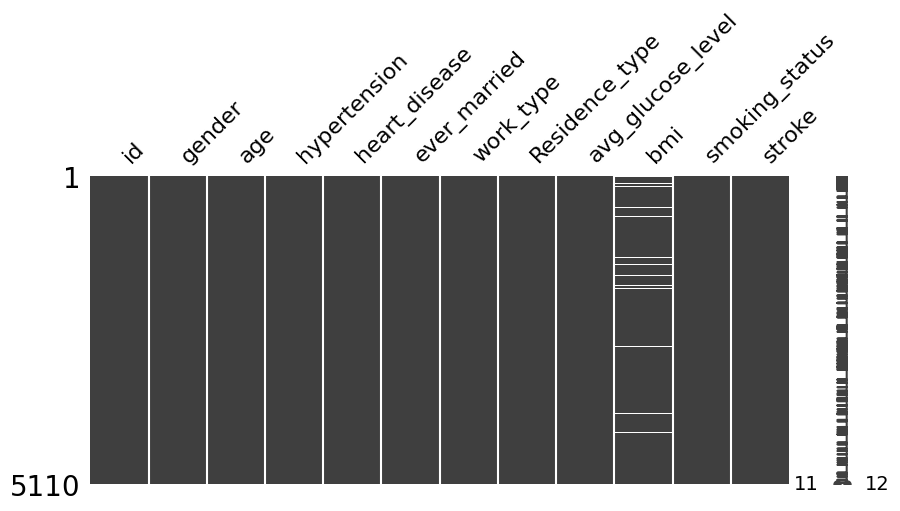

-------------------------------------------------- END - OVERVIEW DATA --------------------------------------------------
-------------------------------------------------- START - EXPLORE NUMERIC --------------------------------------------------
                                                                                
Numeric features: 7 columns
List of columns: ['id' 'age' 'hypertension' 'heart_disease' 'avg_glucose_level' 'bmi'
 'stroke']  
                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  id: numeric column - Nulls: 0(0.0%) - int64 - 5110 distinct values
----------------------------------------------------------------------------------------------------
Descriptive statistics                   Quantile statistics             Top 10 Values  Counts  Frequency(%)
  

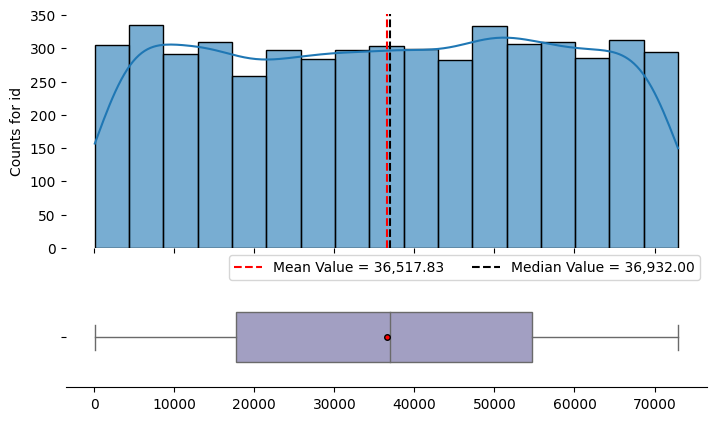

                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  age: numeric column - Nulls: 0(0.0%) - float64 - 104 distinct values
----------------------------------------------------------------------------------------------------
Descriptive statistics             Quantile statistics        Top 10 Values  Counts  Frequency(%)
                  Mean   43.226614             Minimum   0.08          78.0     102         1.996
                   STD   22.612647     5-th percentile    5.0          57.0      95         1.859
              Variance  511.331792                  Q1   25.0          52.0      90         1.761
Coef. of variation(CV)    0.523119              Median   45.0          54.0      87         1.703
              Kurtosis    -0.99101                  Q3   61.0          51.0

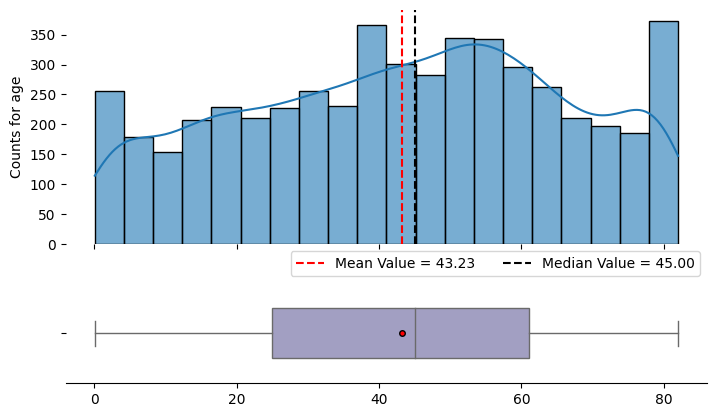

                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  hypertension: numeric column - Nulls: 0(0.0%) - int64 - 2 distinct values
----------------------------------------------------------------------------------------------------
Descriptive statistics           Quantile statistics      Top 10 Values  Counts Frequency(%)
                  Mean  0.097456             Minimum    0           0.0  4612.0       90.254
                   STD  0.296607     5-th percentile  0.0           1.0   498.0        9.746
              Variance  0.087976                  Q1  0.0                                   
Coef. of variation(CV)  3.043494              Median  0.0                                   
              Kurtosis  5.375456                  Q3  0.0                                   
  

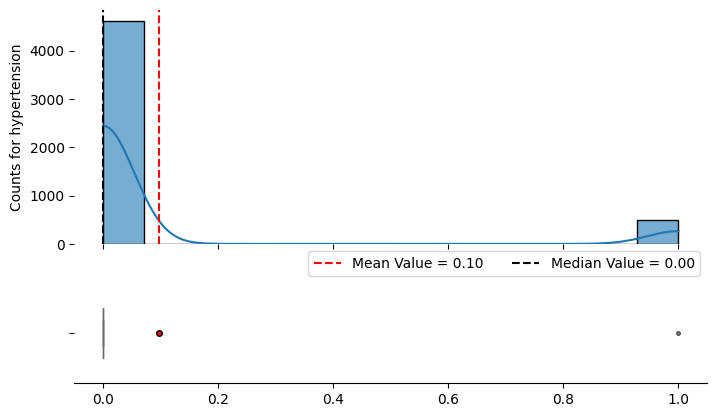

                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  heart_disease: numeric column - Nulls: 0(0.0%) - int64 - 2 distinct values
----------------------------------------------------------------------------------------------------
Descriptive statistics            Quantile statistics      Top 10 Values  Counts Frequency(%)
                  Mean   0.054012             Minimum    0           0.0  4834.0       94.599
                   STD   0.226063     5-th percentile  0.0           1.0   276.0        5.401
              Variance   0.051104                  Q1  0.0                                   
Coef. of variation(CV)   4.185442              Median  0.0                                   
              Kurtosis  13.586052                  Q3  0.0                               

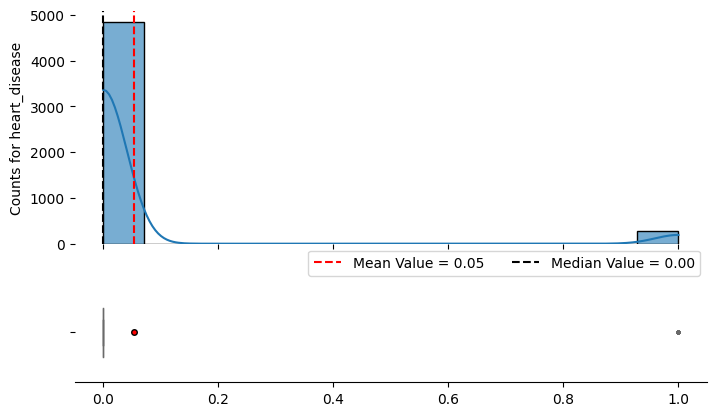

                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  avg_glucose_level: numeric column - Nulls: 0(0.0%) - float64 - 3979 distinct values
----------------------------------------------------------------------------------------------------
Descriptive statistics             Quantile statistics           Top 10 Values  Counts  Frequency(%)
                  Mean  106.147677             Minimum     55.12         93.88       6         0.117
                   STD    45.28356     5-th percentile   60.7135         91.85       5         0.098
              Variance  2050.60082                  Q1    77.245         83.16       5         0.098
Coef. of variation(CV)    0.426609              Median    91.885          73.0       5         0.098
              Kurtosis    1.680479           

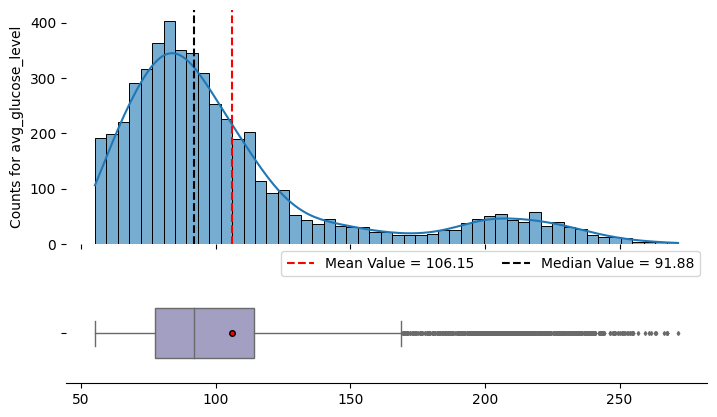

                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  bmi: numeric column - Nulls: 201(3.93%) - float64 - 419 distinct values
----------------------------------------------------------------------------------------------------
Descriptive statistics            Quantile statistics        Top 10 Values  Counts  Frequency(%)
                  Mean  28.893237             Minimum   10.3           NaN     201         3.933
                   STD   7.854067     5-th percentile  17.64          28.7      41         0.802
              Variance  61.686364                  Q1   23.5          28.4      38         0.744
Coef. of variation(CV)   0.271831              Median   28.1          27.7      37         0.724
              Kurtosis   3.362659                  Q3   33.1          26.1   

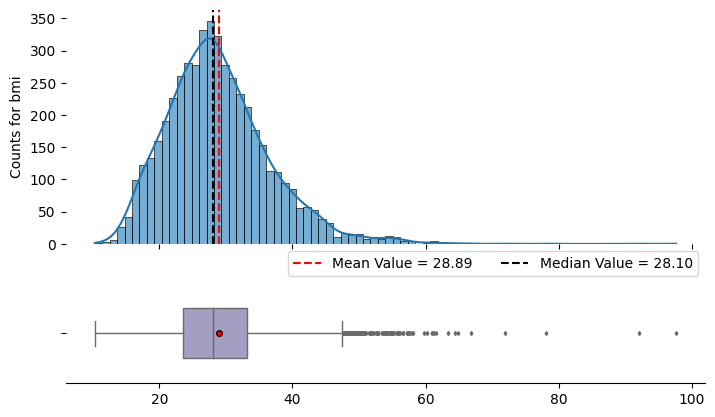

                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  stroke: numeric column - Nulls: 0(0.0%) - int64 - 2 distinct values
----------------------------------------------------------------------------------------------------
Descriptive statistics            Quantile statistics      Top 10 Values  Counts Frequency(%)
                  Mean   0.048728             Minimum    0           0.0  4861.0       95.127
                   STD    0.21532     5-th percentile  0.0           1.0   249.0        4.873
              Variance   0.046363                  Q1  0.0                                   
Coef. of variation(CV)   4.418813              Median  0.0                                   
              Kurtosis  15.589736                  Q3  0.0                                   
  

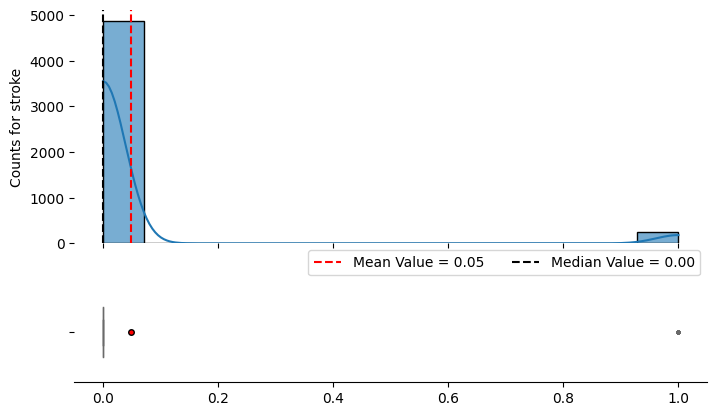

                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
Correlations for columns: ['id' 'age' 'hypertension' 'heart_disease' 'avg_glucose_level' 'bmi'
 'stroke']:
----------------------------------------------------------------------------------------------------


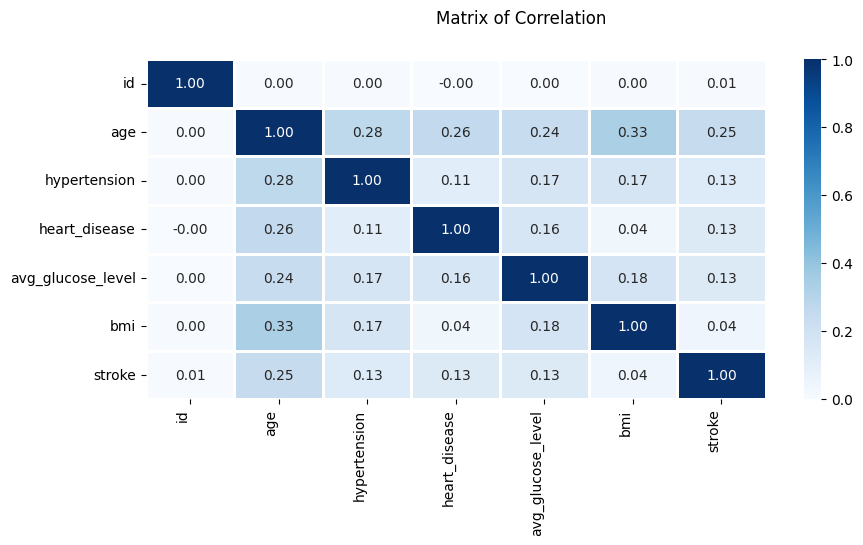

----------------------------------------------------------------------------------------------------
Correlations higher than corr_threshold= 0.1:
                                             Correlated features  Correlation
               [!] Warning:'age' is correlated to 'hypertension'        0.276
              [!] Warning:'age' is correlated to 'heart_disease'        0.264
          [!] Warning:'age' is correlated to 'avg_glucose_level'        0.238
                        [!] Warning:'age' is correlated to 'bmi'        0.333
                     [!] Warning:'age' is correlated to 'stroke'        0.245
     [!] Warning:'hypertension' is correlated to 'heart_disease'        0.108
 [!] Warning:'hypertension' is correlated to 'avg_glucose_level'        0.174
               [!] Warning:'hypertension' is correlated to 'bmi'        0.168
            [!] Warning:'hypertension' is correlated to 'stroke'        0.128
[!] Warning:'heart_disease' is correlated to 'avg_glucose_level'        0

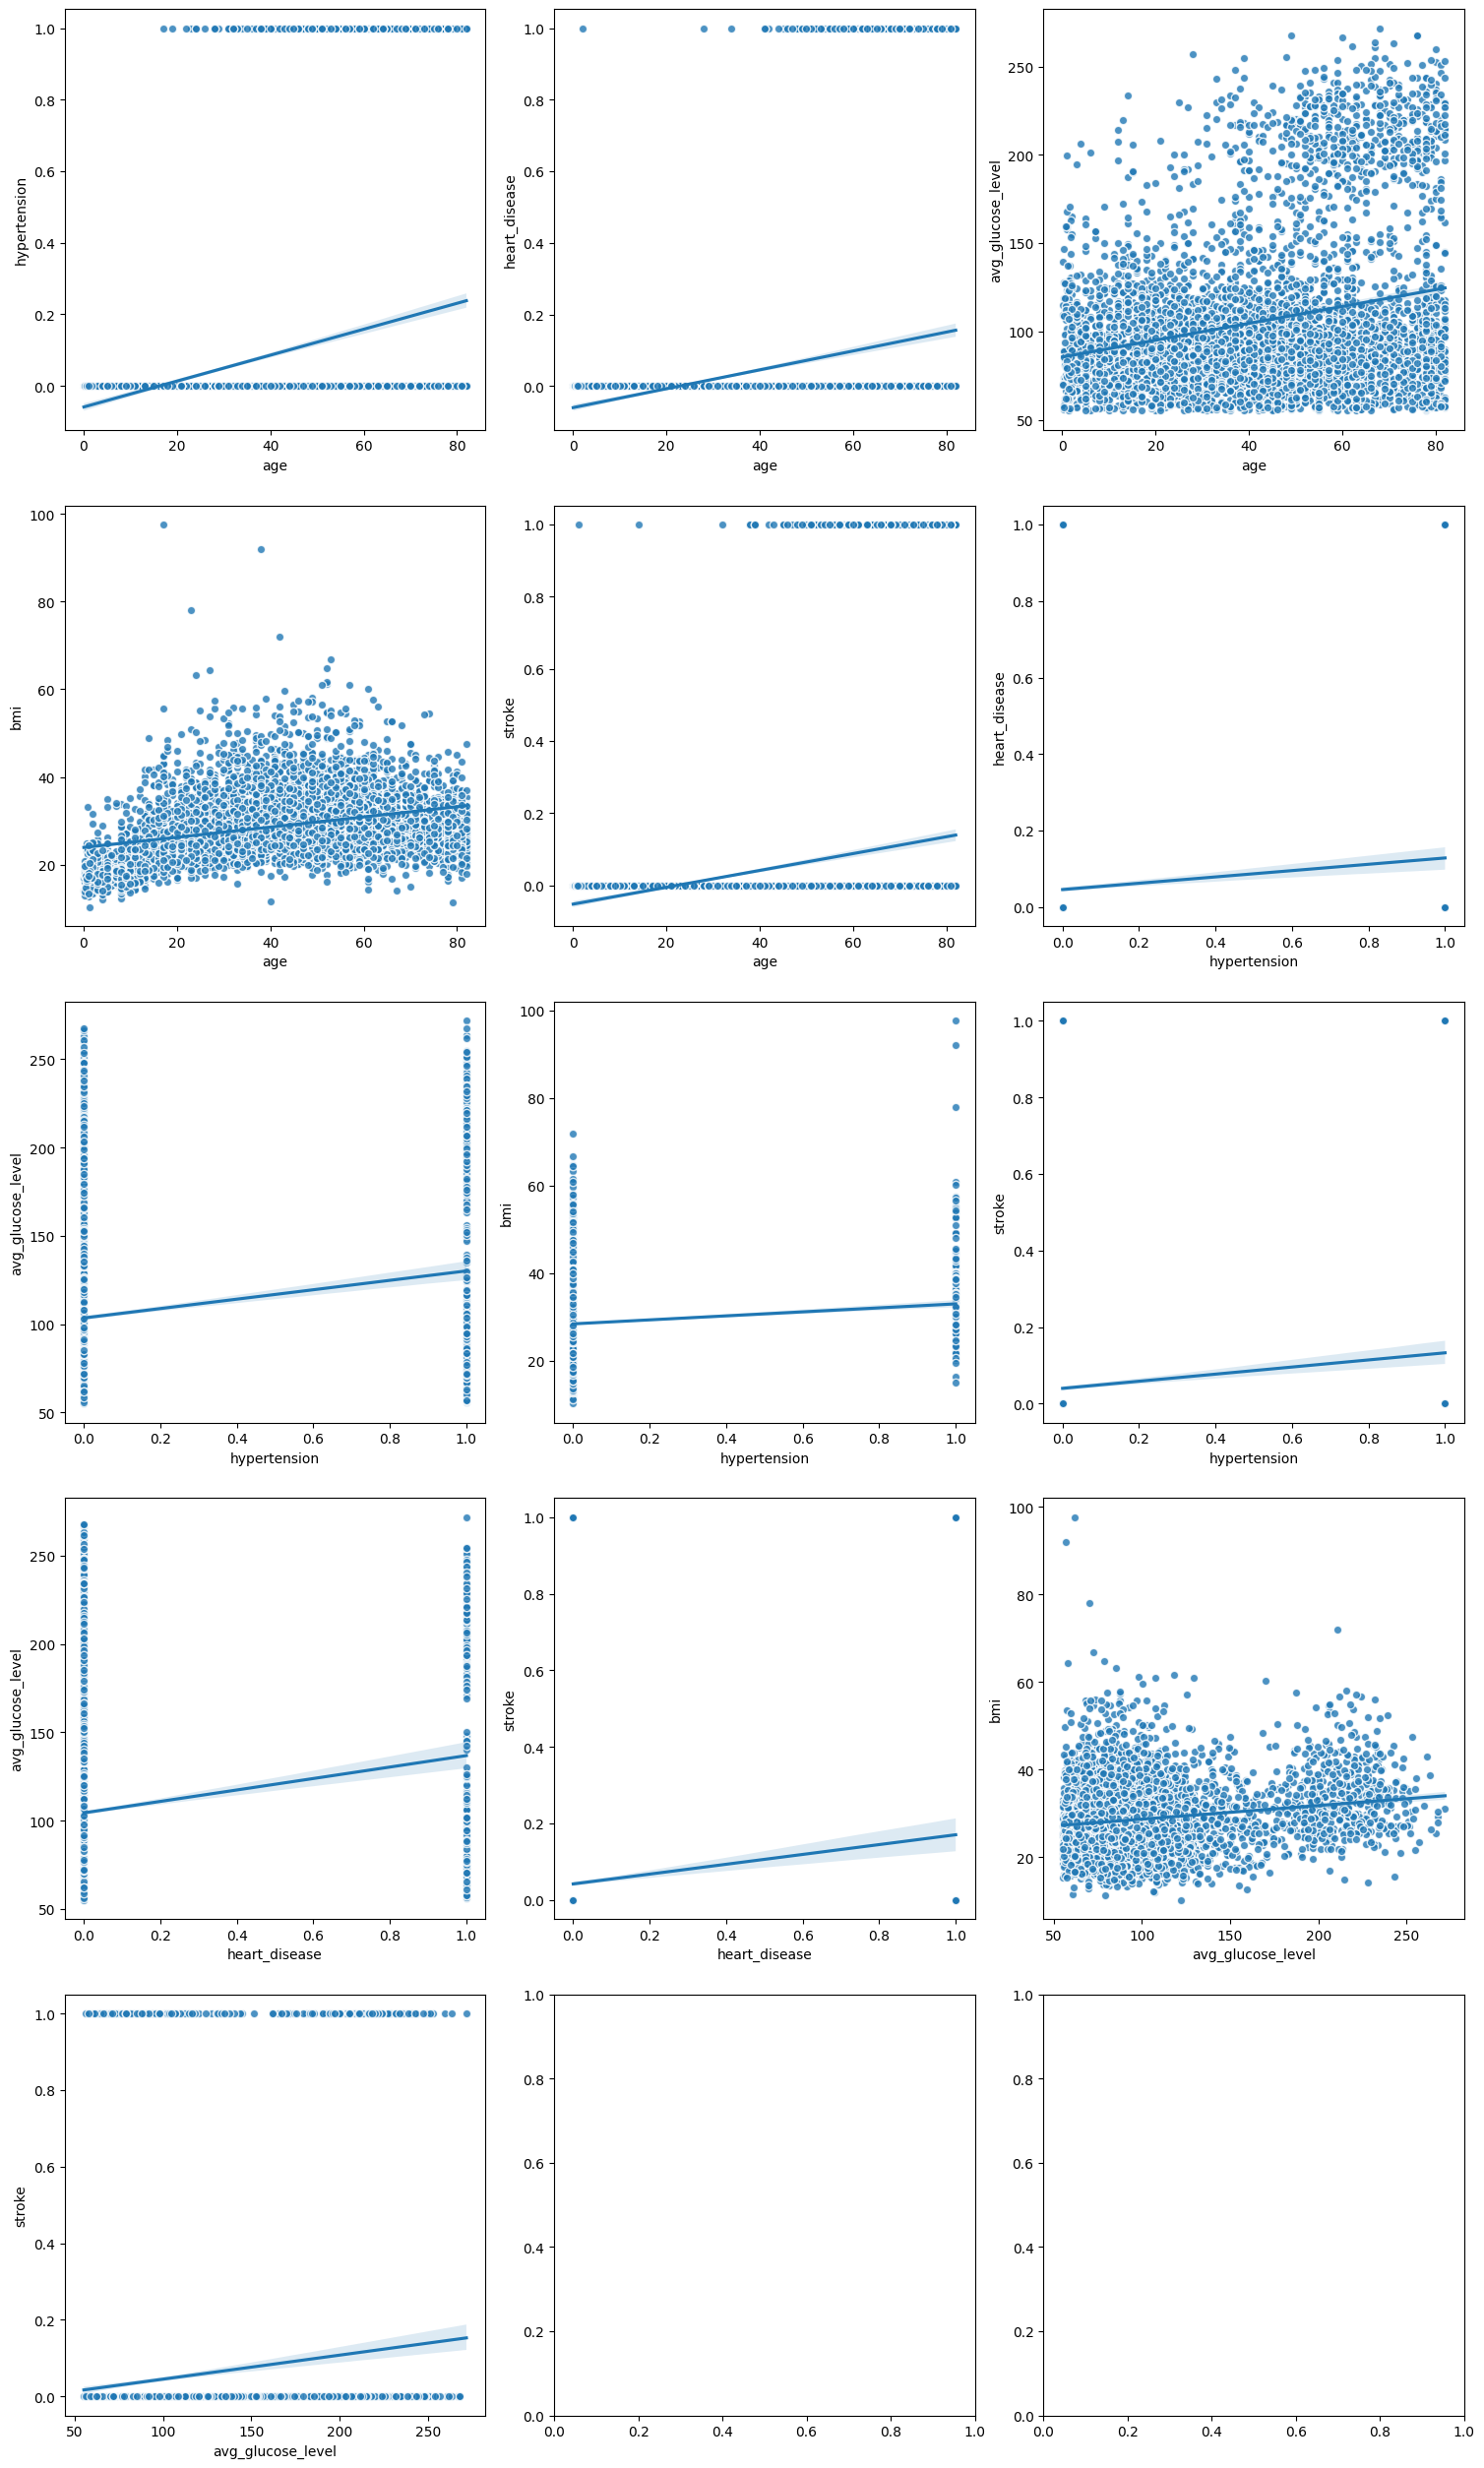

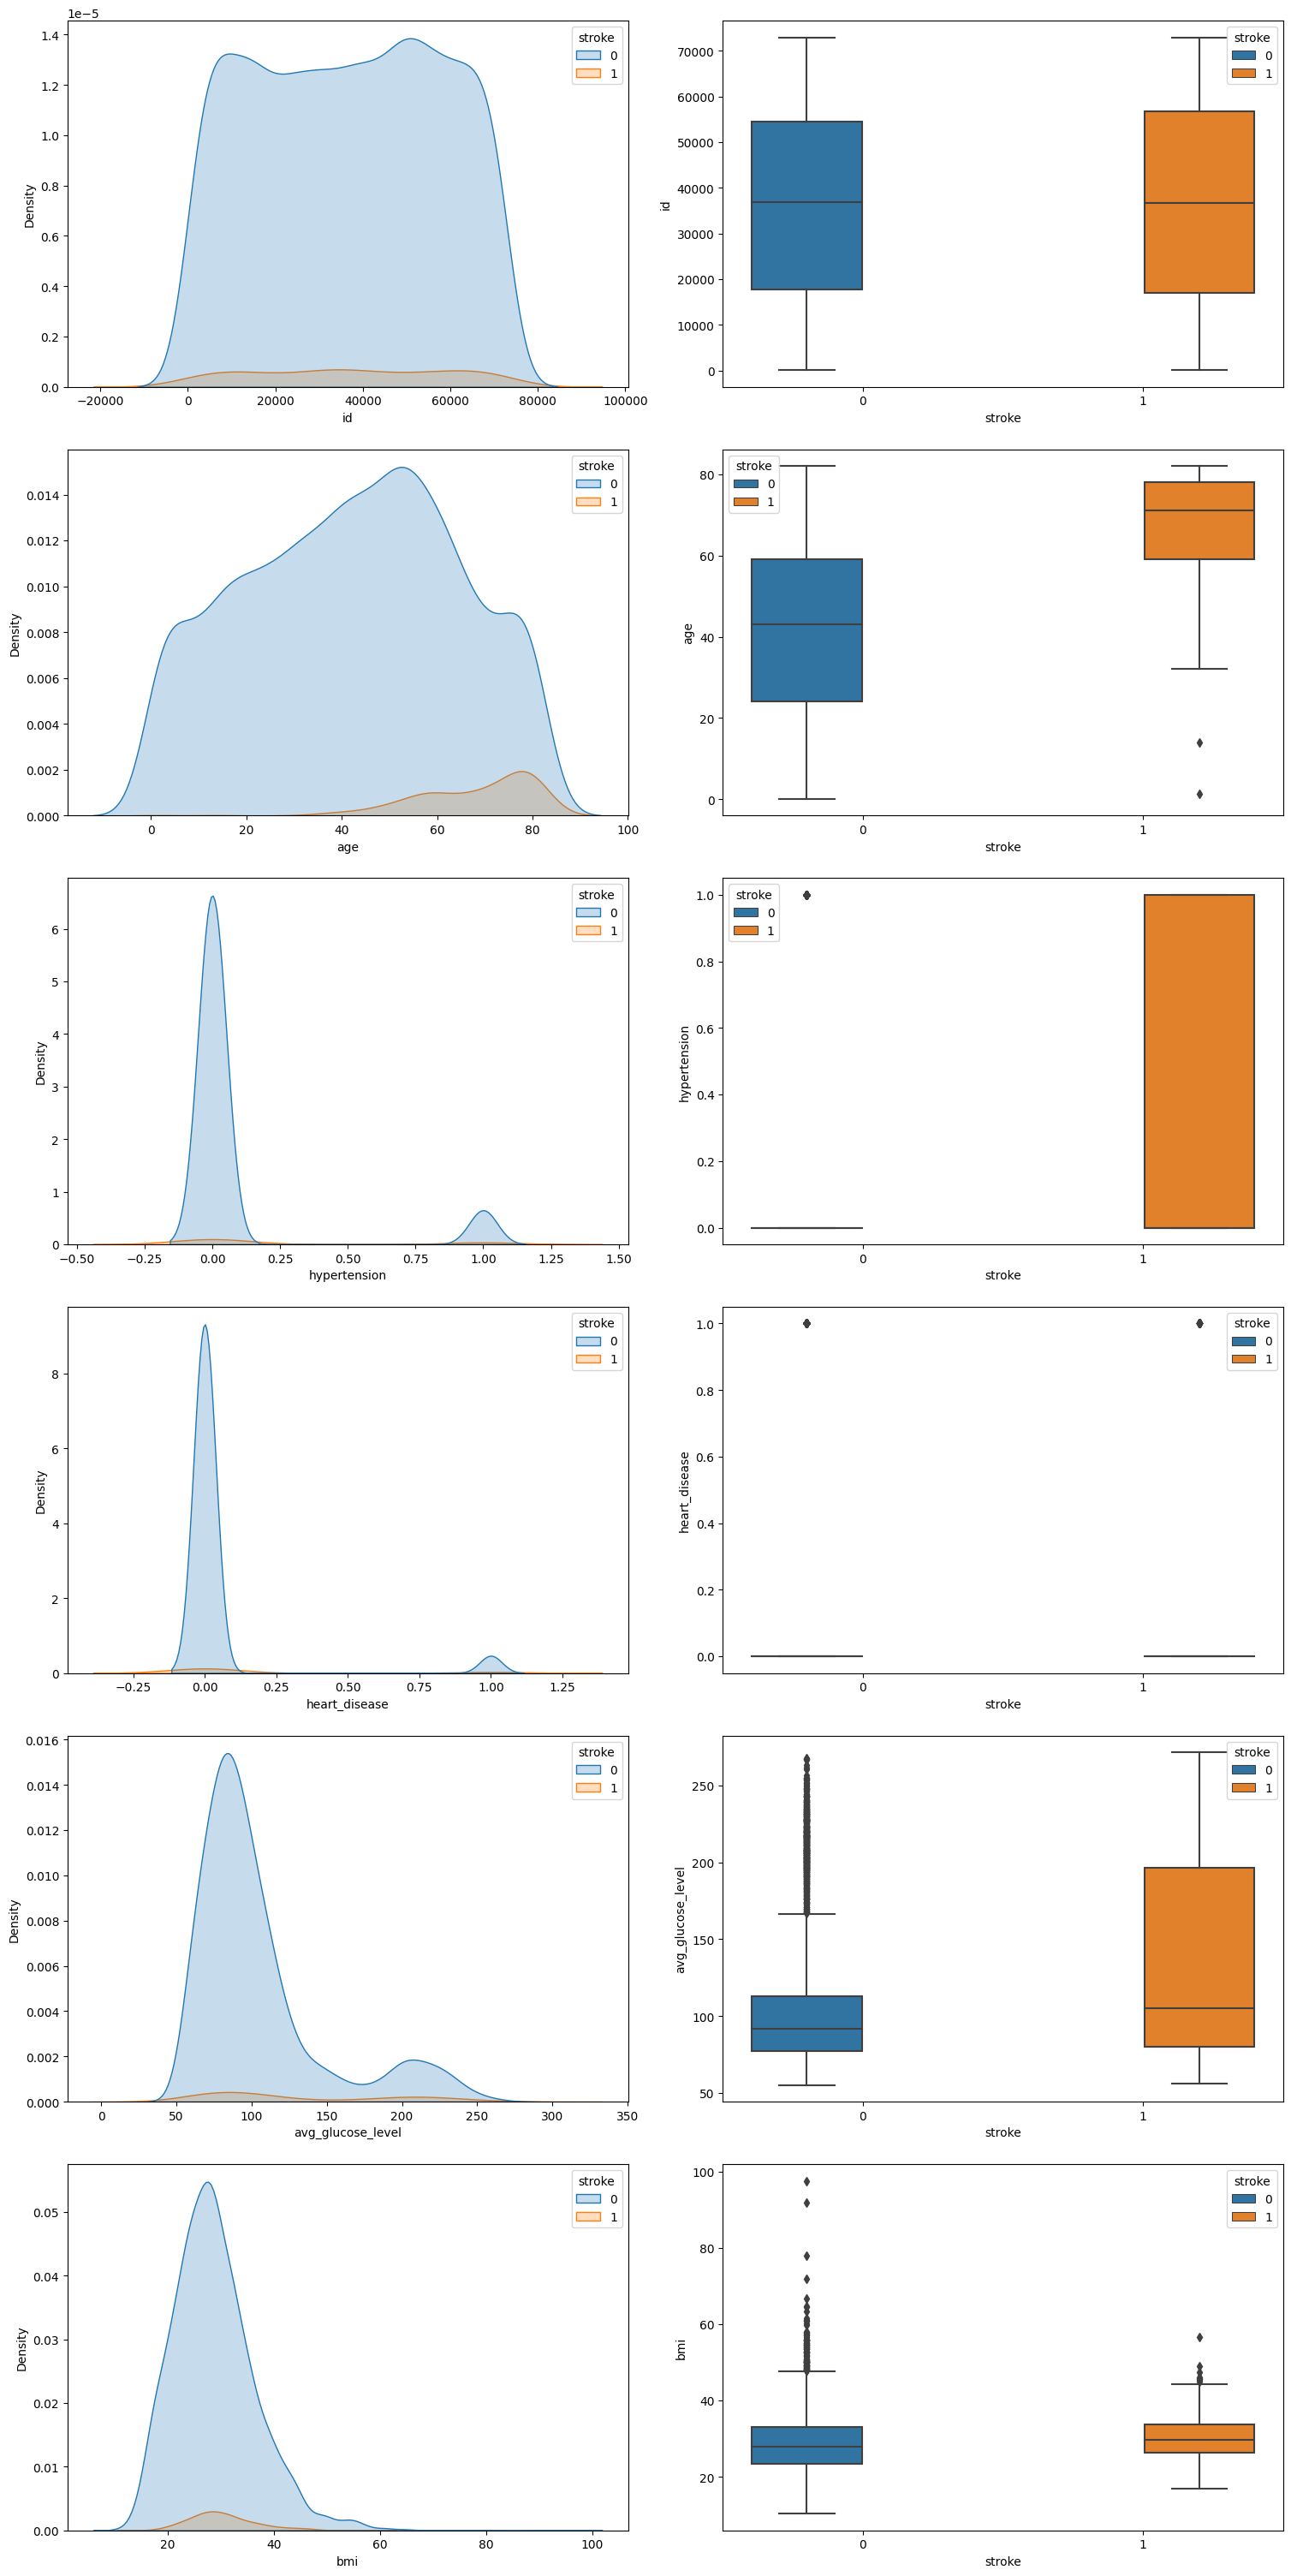

-------------------------------------------------- END - EXPLORE NUMERIC --------------------------------------------------
-------------------------------------------------- START - EXPLORE CATEGORICAL --------------------------------------------------
                                                                                
Categorical features: 5 columns
List of columns: ['gender' 'ever_married' 'work_type' 'Residence_type' 'smoking_status']  
                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  gender: catgorical column - Nulls: 0(0.0%) - object - 3 distinct values
----------------------------------------------------------------------------------------------------
Top 10 Values  Counts  Frequency(%)
       Female    2994        58.591
         Male    2115        41.

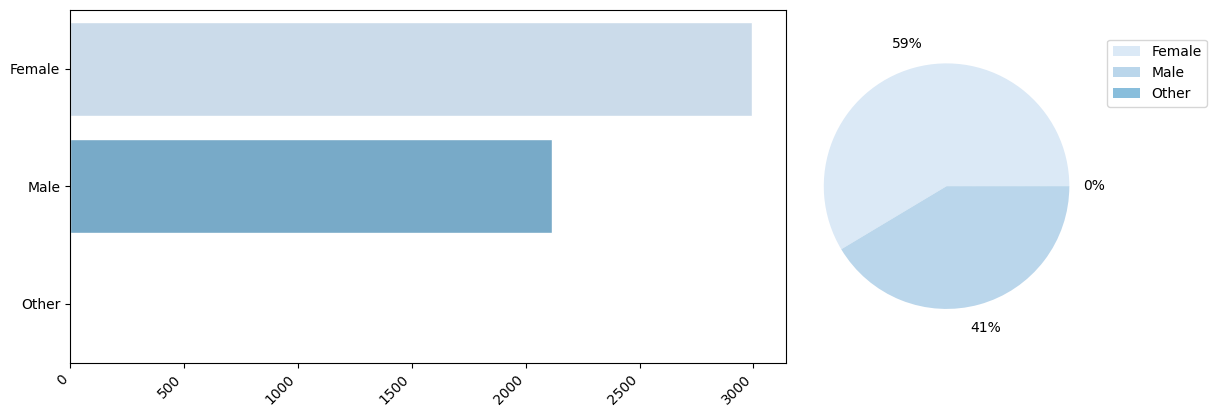

                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  ever_married: catgorical column - Nulls: 0(0.0%) - object - 2 distinct values
----------------------------------------------------------------------------------------------------
Top 10 Values  Counts  Frequency(%)
          Yes    3353        65.616
           No    1757        34.384
                                                                                
----------------------------------------------------------------------------------------------------
Alerts for feature 'ever_married':
- [!] Warning: Class imbalance detected within column 'ever_married'
- Most common value: 'Yes' occurs 3353 times (65.62%)
- Not constant or quasi-constant(threshold at 98%).
                                                        

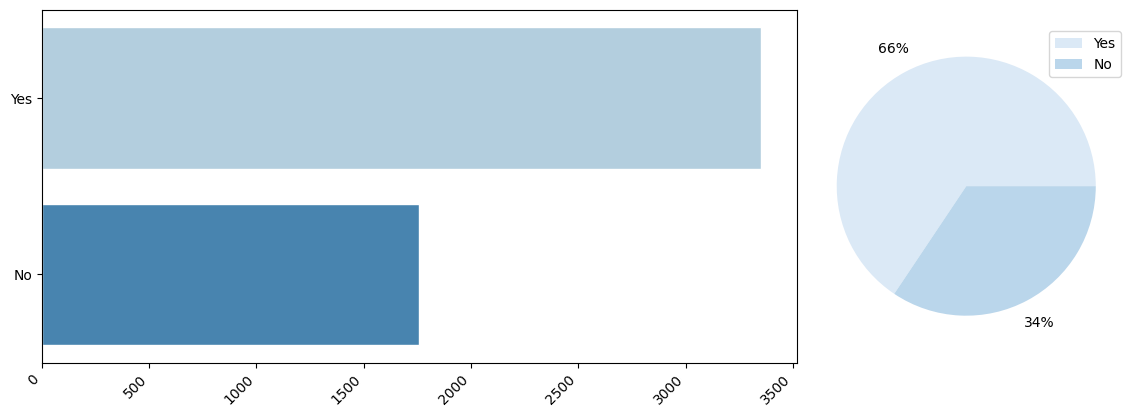

                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  work_type: catgorical column - Nulls: 0(0.0%) - object - 5 distinct values
----------------------------------------------------------------------------------------------------
Top 10 Values  Counts  Frequency(%)
      Private    2925        57.241
Self-employed     819        16.027
     children     687        13.444
     Govt_job     657        12.857
 Never_worked      22         0.431
                                                                                
----------------------------------------------------------------------------------------------------
Alerts for feature 'work_type':
- [!] Warning: Class imbalance detected within column 'work_type'
- Most common value: 'Private' occurs 2925 times (57.24%)
- Not

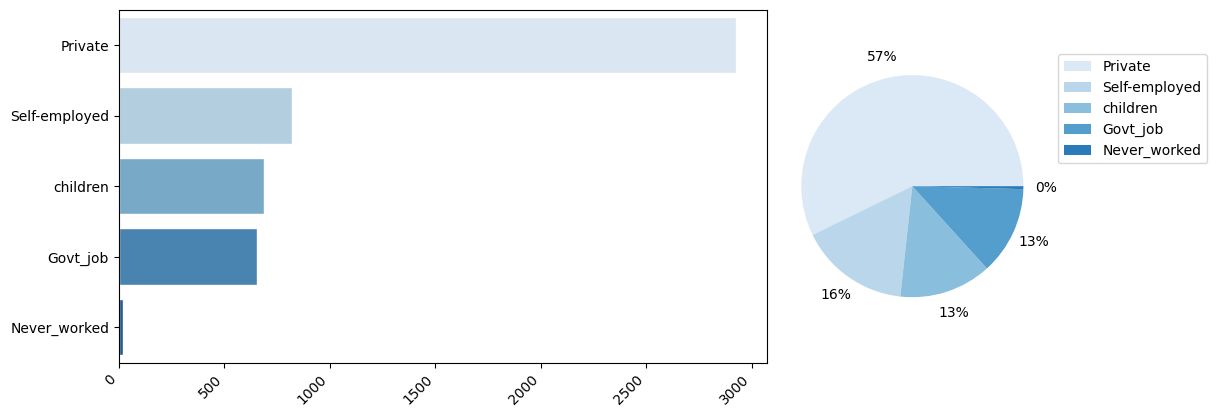

                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  Residence_type: catgorical column - Nulls: 0(0.0%) - object - 2 distinct values
----------------------------------------------------------------------------------------------------
Top 10 Values  Counts  Frequency(%)
        Urban    2596        50.802
        Rural    2514        49.198
                                                                                
----------------------------------------------------------------------------------------------------
Alerts for feature 'Residence_type':
- Most common value: 'Urban' occurs 2596 times (50.8%)
- Not constant or quasi-constant(threshold at 98%).
                                                                                
---------------------------------------

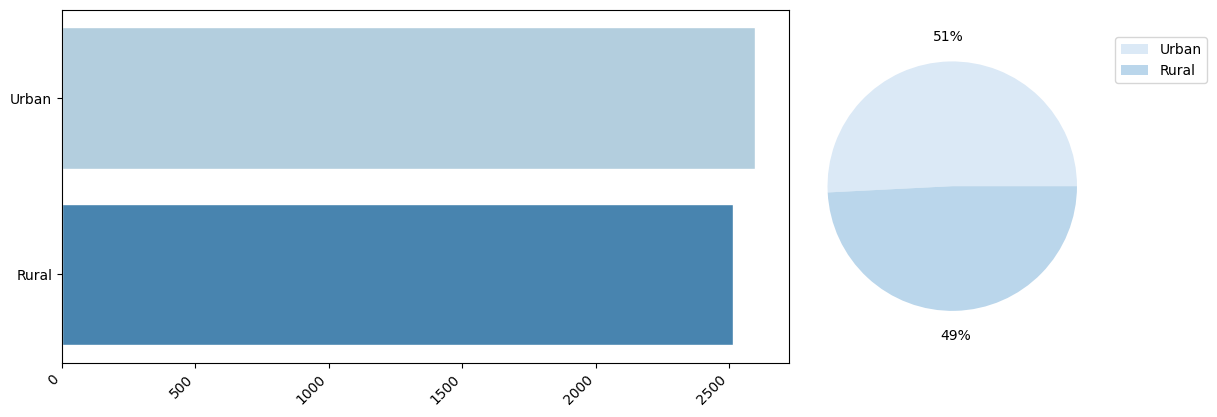

                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
  smoking_status: catgorical column - Nulls: 0(0.0%) - object - 4 distinct values
----------------------------------------------------------------------------------------------------
  Top 10 Values  Counts  Frequency(%)
   never smoked    1892        37.025
        Unknown    1544        30.215
formerly smoked     885        17.319
         smokes     789        15.440
                                                                                
----------------------------------------------------------------------------------------------------
Alerts for feature 'smoking_status':
- [!] Warning: Class imbalance detected within column 'smoking_status'
- Most common value: 'never smoked' occurs 1892 times (37.03%)
- Not const

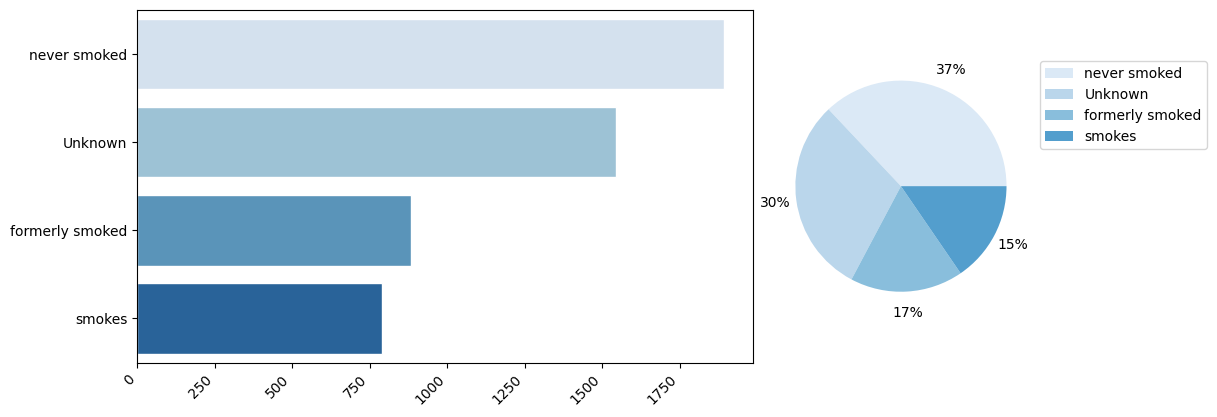

                                                                                
                                                                                
----------------------------------------------------------------------------------------------------
Correlations for columns: ['gender' 'ever_married' 'work_type' 'Residence_type' 'smoking_status']
----------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------
Contingency table for 'gender' against 'ever_married'
---------------------------------------------------------------------------
ever_married   No   Yes
gender                 
Female        993  2001
Male          763  1352
Other           1     0

[!] Warning: P-value: 0.038, (p-value < sig_level), Null hypothesis rejected, 'gender' is associated with 'ever_married'


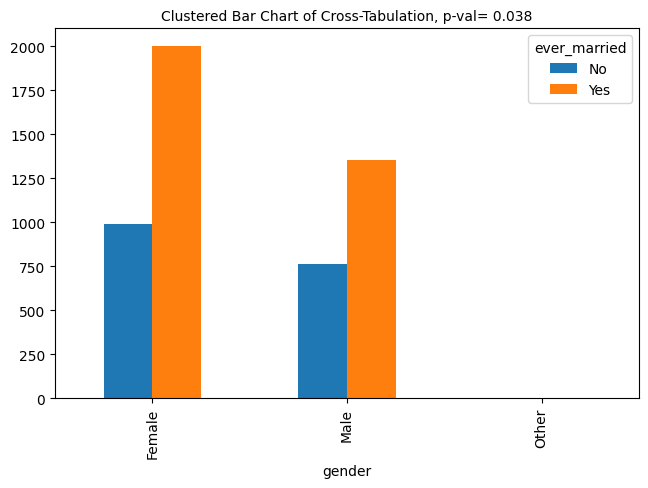

---------------------------------------------------------------------------
Contingency table for 'gender' against 'work_type'
---------------------------------------------------------------------------
work_type  Govt_job  Never_worked  Private  Self-employed  children
gender                                                             
Female          399            11     1754            504       326
Male            258            11     1170            315       361
Other             0             0        1              0         0

[!] Warning: P-value: 0.0, (p-value < sig_level), Null hypothesis rejected, 'gender' is associated with 'work_type'


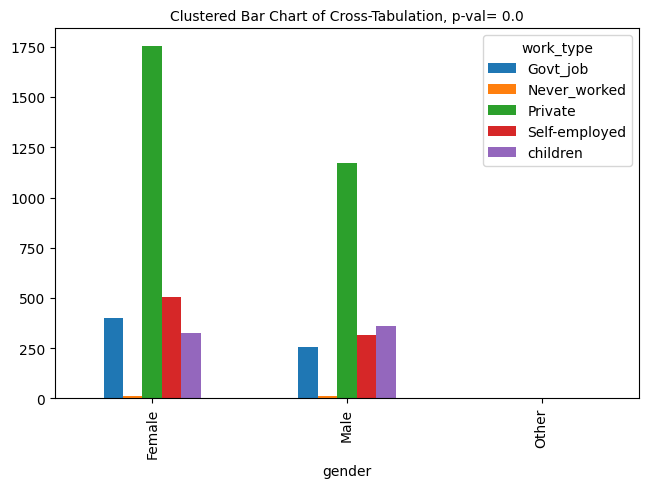

---------------------------------------------------------------------------
Contingency table for 'gender' against 'Residence_type'
---------------------------------------------------------------------------
Residence_type  Rural  Urban
gender                      
Female           1465   1529
Male             1048   1067
Other               1      0

P-value: 0.542, (p-value > sig_level), Null hypothesis not rejected, not enough evidence to suggest association between 'gender' and 'Residence_type'


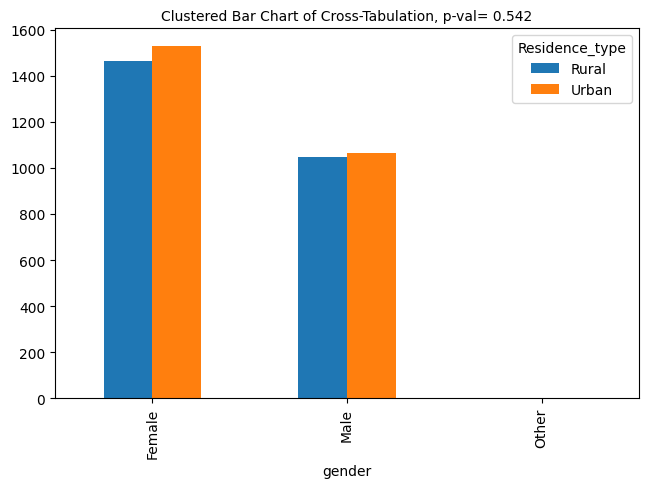

---------------------------------------------------------------------------
Contingency table for 'gender' against 'smoking_status'
---------------------------------------------------------------------------
smoking_status  Unknown  formerly smoked  never smoked  smokes
gender                                                        
Female              836              477          1229     452
Male                708              407           663     337
Other                 0                1             0       0

[!] Warning: P-value: 0.0, (p-value < sig_level), Null hypothesis rejected, 'gender' is associated with 'smoking_status'


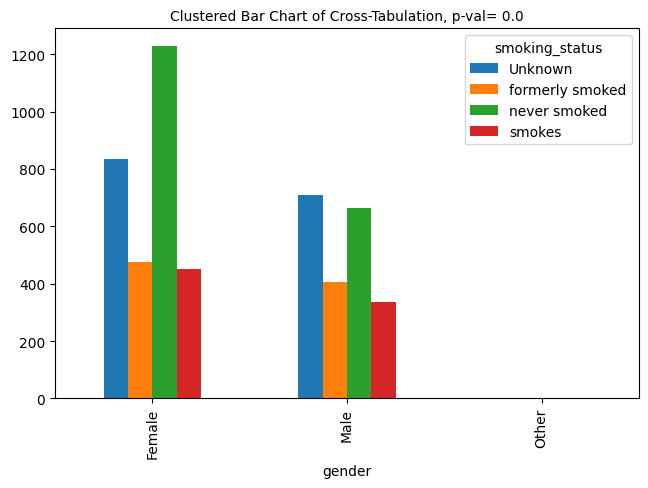

---------------------------------------------------------------------------
Contingency table for 'ever_married' against 'work_type'
---------------------------------------------------------------------------
work_type     Govt_job  Never_worked  Private  Self-employed  children
ever_married                                                          
No                 117            22      821            110       687
Yes                540             0     2104            709         0

[!] Warning: P-value: 0.0, (p-value < sig_level), Null hypothesis rejected, 'ever_married' is associated with 'work_type'


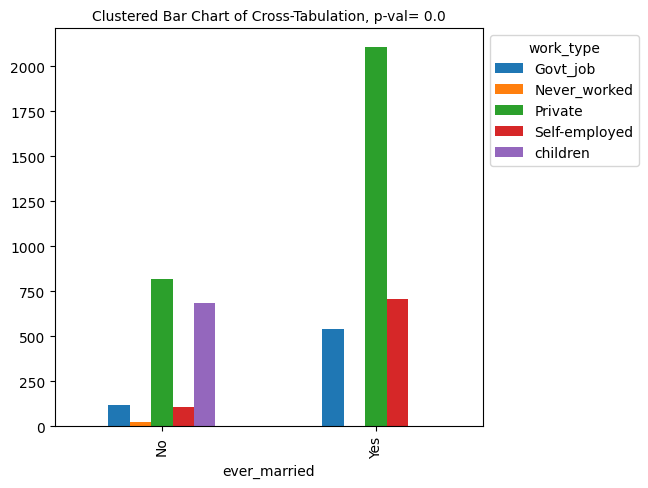

---------------------------------------------------------------------------
Contingency table for 'ever_married' against 'Residence_type'
---------------------------------------------------------------------------
Residence_type  Rural  Urban
ever_married                
No                872    885
Yes              1642   1711

P-value: 0.676, (p-value > sig_level), Null hypothesis not rejected, not enough evidence to suggest association between 'ever_married' and 'Residence_type'


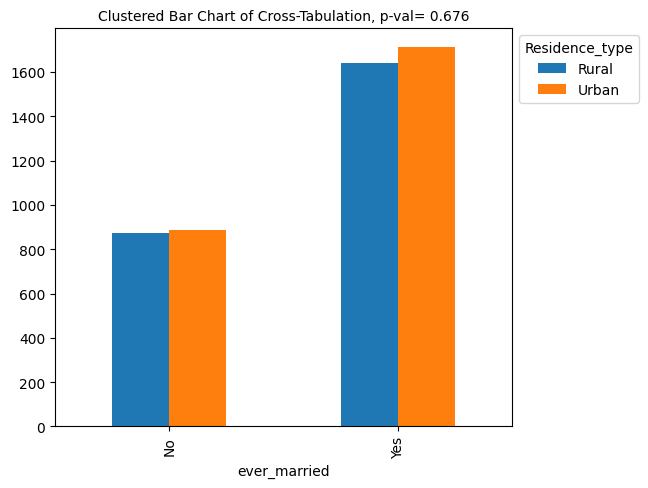

---------------------------------------------------------------------------
Contingency table for 'ever_married' against 'smoking_status'
---------------------------------------------------------------------------
smoking_status  Unknown  formerly smoked  never smoked  smokes
ever_married                                                  
No                  901              147           530     179
Yes                 643              738          1362     610

[!] Warning: P-value: 0.0, (p-value < sig_level), Null hypothesis rejected, 'ever_married' is associated with 'smoking_status'


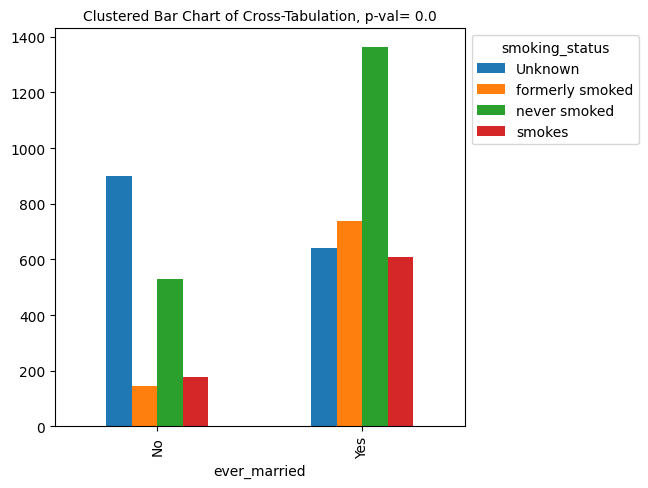

---------------------------------------------------------------------------
Contingency table for 'work_type' against 'Residence_type'
---------------------------------------------------------------------------
Residence_type  Rural  Urban
work_type                   
Govt_job          312    345
Never_worked        7     15
Private          1462   1463
Self-employed     393    426
children          340    347

P-value: 0.325, (p-value > sig_level), Null hypothesis not rejected, not enough evidence to suggest association between 'work_type' and 'Residence_type'


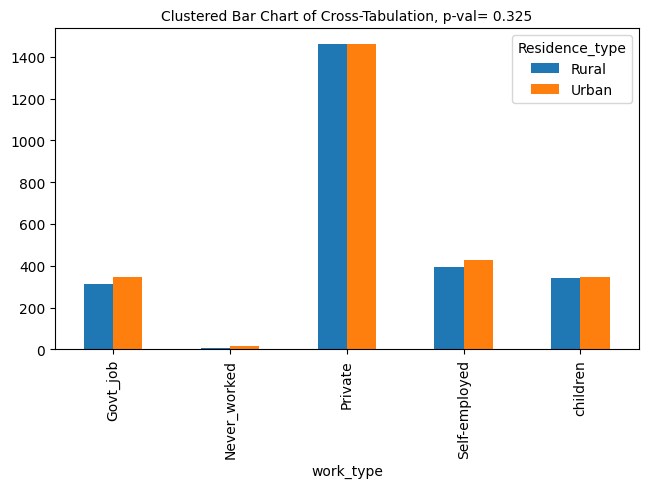

---------------------------------------------------------------------------
Contingency table for 'work_type' against 'smoking_status'
---------------------------------------------------------------------------
smoking_status  Unknown  formerly smoked  never smoked  smokes
work_type                                                     
Govt_job            122              133           282     120
Never_worked          8                0            14       0
Private             640              531          1211     543
Self-employed       156              208           331     124
children            618               13            54       2

[!] Warning: P-value: 0.0, (p-value < sig_level), Null hypothesis rejected, 'work_type' is associated with 'smoking_status'


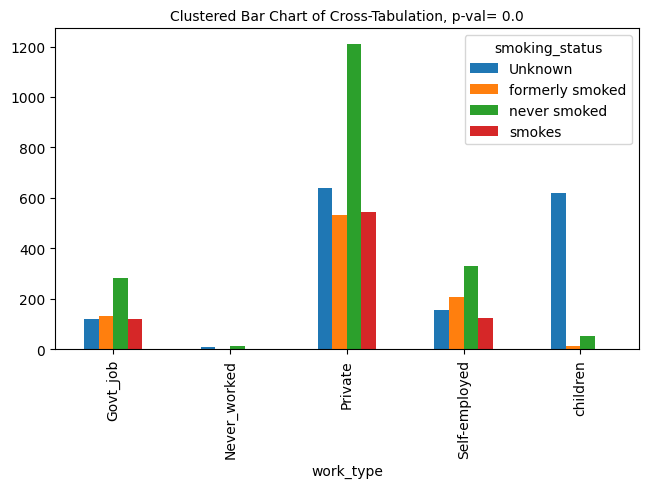

---------------------------------------------------------------------------
Contingency table for 'Residence_type' against 'smoking_status'
---------------------------------------------------------------------------
smoking_status  Unknown  formerly smoked  never smoked  smokes
Residence_type                                                
Rural               762              428           961     363
Urban               782              457           931     426

P-value: 0.145, (p-value > sig_level), Null hypothesis not rejected, not enough evidence to suggest association between 'Residence_type' and 'smoking_status'


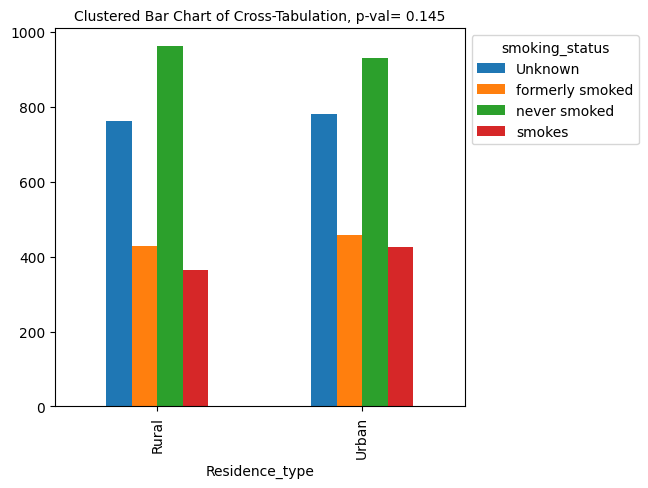

-------------------------------------------------- END - EXPLORE CATEGORICAL --------------------------------------------------


In [12]:
overview_data(df)
explore_numeric(df,corr_threshold=0.1,target="stroke")
explore_categorical(df)